In [1]:
import snowflake.connector
import os
conn = snowflake.connector.connect(
    user=os.environ['SNOWFLAKE_USER'],
    role=os.environ['SNOWFLAKE_ROLE'],
    password=os.environ['SNOWFLAKE_PASSWORD'],
    account=os.environ['SNOWFLAKE_ACCOUNT'],
    warehouse=os.environ['SNOWFLAKE_WAREHOUSE'],
    database=os.environ['SNOWFLAKE_DATABASE'],
    schema=os.environ['SNOWFLAKE_SCHEMA']
)



In [2]:
# %conda install "snowflake-connector-python[pandas]"


In [2]:
# Create a cursor object.
import pandas as pd
def run_sql(sql: str, ctx=conn):
    return conn.cursor().execute(sql)

import functools
import time

@functools.cache
def sql_to_df(sql_query, pre_hook=[], ctx=conn):
    print(f"RUNNING pre-hook: {pre_hook}")
    for s in pre_hook:
        run_sql(s,conn)
        # print(f"RUNNING SQL: {sql_query}")

    # todo: move to latest method of pandas dataframe fetching
    # may need to upgrade python: https://github.com/snowflakedb/snowflake-connector-python/issues/986#issuecomment-1115354587
    
    trimmed_lowered = sql_query.strip().lower()
    if trimmed_lowered.startswith('select') or trimmed_lowered.startswith('with'):
        print(f"using arrow to fetch results...")
        cur = ctx.cursor()
        cur.execute(sql_query)
        data = cur.fetch_pandas_all() 
        cur.close()
    else:
        data = pd.read_sql(
            sql_query,
            ctx,
        )
    
    data.columns = data.columns.str.lower()
    return data

In [9]:
%%markdown
# Idle Time 
We compute: 
- idle time for warehouse 
- some ballpark/conservative estimates for savings based on 20% idle time reduction

# Idle Time 
We compute: 
- idle time for warehouse 
- some ballpark/conservative estimates for savings based on 20% idle time reduction


RUNNING pre-hook: []
using arrow to fetch results...


auto_suspend  warehouse_id                     warehouse_name  \
125           NaN           102                EBATES_CA_ODS_DE_WH   
124           NaN           104               REBATES_JP_ODS_DE_WH   
126           NaN           185                    FOUNDATION_2_WH   
127           NaN           222  ENRICH_SCIENCE_ENGG_FORECAST_1_WH   
123           NaN             4                         TABLEAU_WH   
..            ...           ...                                ...   
4             NaN           123                    MESSAGE_GEAR_WH   
22            NaN           144                CAMPAIGN_ADMIN_1_WH   
0             NaN            24                     PLATFORM_DE_WH   
16            NaN            61                        SALES_BU_WH   
2             NaN             7                         ATSCALE_WH   

                   warehouse_sizes  max_cluster_number  active_hours  \
125              [\n  "X-Small"\n]                   1      0.068124   
124              [\n  "X-Small"\n]                   1      0.077212   
126               [\n  "Medium"\n]                   1      0.034183   
127               [\n  "Medium"\n]                   1      0.041320   
123               [\n  "Medium"\n]                   1      0.113943   
..                             ...                 ...           ...   
4                 [\n  "Medium"\n]                   5    347.321481   
22                [\n  "Medium"\n]                   5    459.275916   
0                  [\n  "Large"\n]                   2    432.239032   
16                 [\n  "Large"\n]                   2    305.093959   
2    [\n  "X-Large",\n  "Large"\n]                   5    175.805648   

     idle_hours   pct_idle  dollars_used_compute  \
125    0.067242  98.704577               0.13640   
124    0.075659  97.988934               0.15455   
126    0.016856  49.310894               0.27280   
127    0.016890  40.875417               0.32780   
123    0.021389  18.771804               0.90420   
..          ...        ...                   ...   
4    160.825499  46.304507            5084.01740   
22    59.434241  12.940857            5932.74165   
0    180.661856  41.796747            7156.26505   
16    34.703401  11.374660            7383.35730   
2     72.912900  41.473582            8887.60235   

     dollars_used_single_cluster_inferred  \
125                              0.134886   
124                              0.152879   
126                              0.270728   
127                              0.327254   
123                              0.902429   
..                                    ...   
4                             2750.786130   
22                            3637.465256   
0                             6846.666266   
16                            4832.688304   
2                             4656.091748   

     dollars_used_addtl_clusters_inferred  dollars_used_idle  \
125                              0.000000           0.134633   
124                              0.000000           0.151442   
126                              0.000000           0.134520   
127                              0.000000           0.133990   
123                              0.000000           0.169735   
..                                    ...                ...   
4                             2333.231270        1273.737953   
22                            2295.276394         470.719190   
0                              309.598784        2861.683805   
16                            2550.668996         549.701865   
2                             4231.510602        1931.048029   

     dollars_used_active  cost_savings_estimate  \
125             0.001767               0.026927   
124             0.003108               0.030288   
126             0.138280               0.026904   
127             0.193810               0.026798   
123             0.734465               0.033947   
..                   ...                    ...   
4      

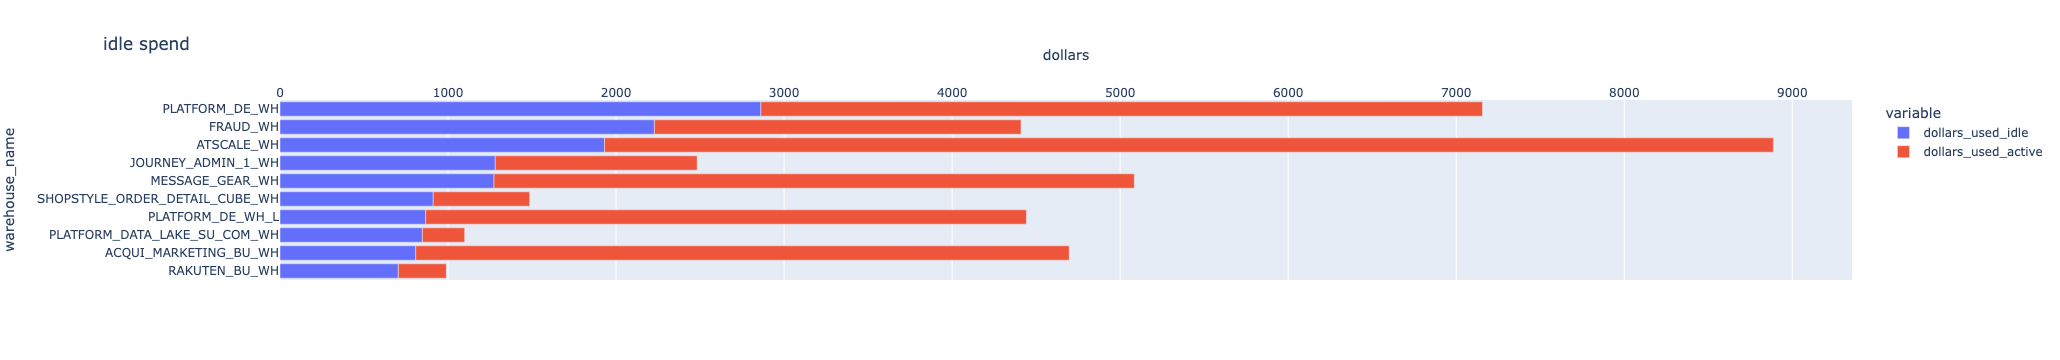

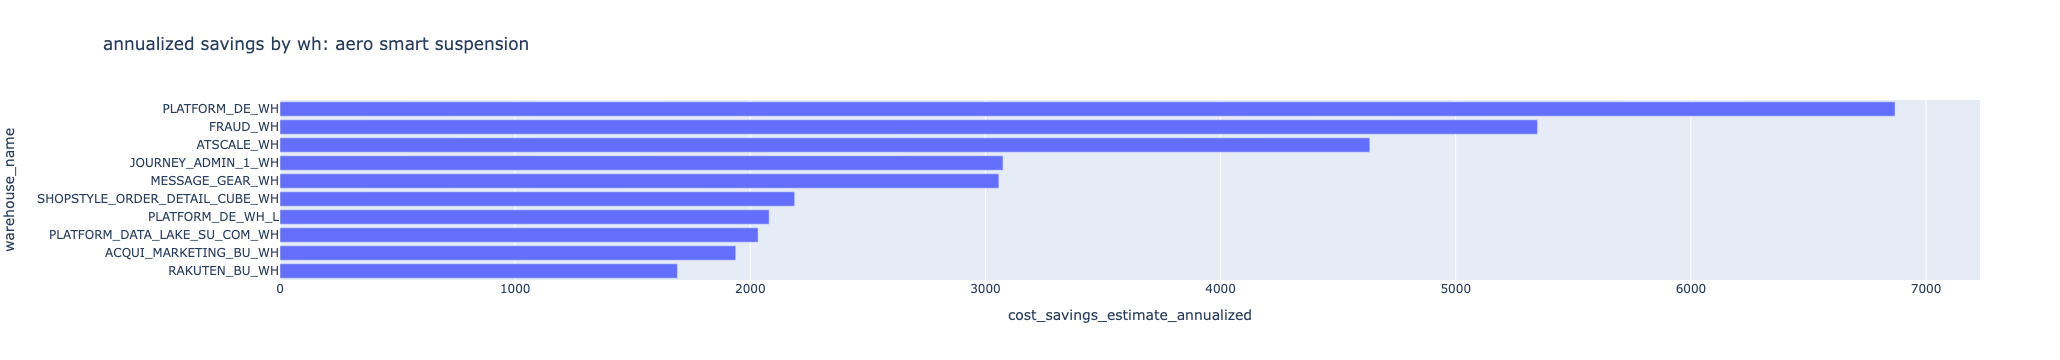

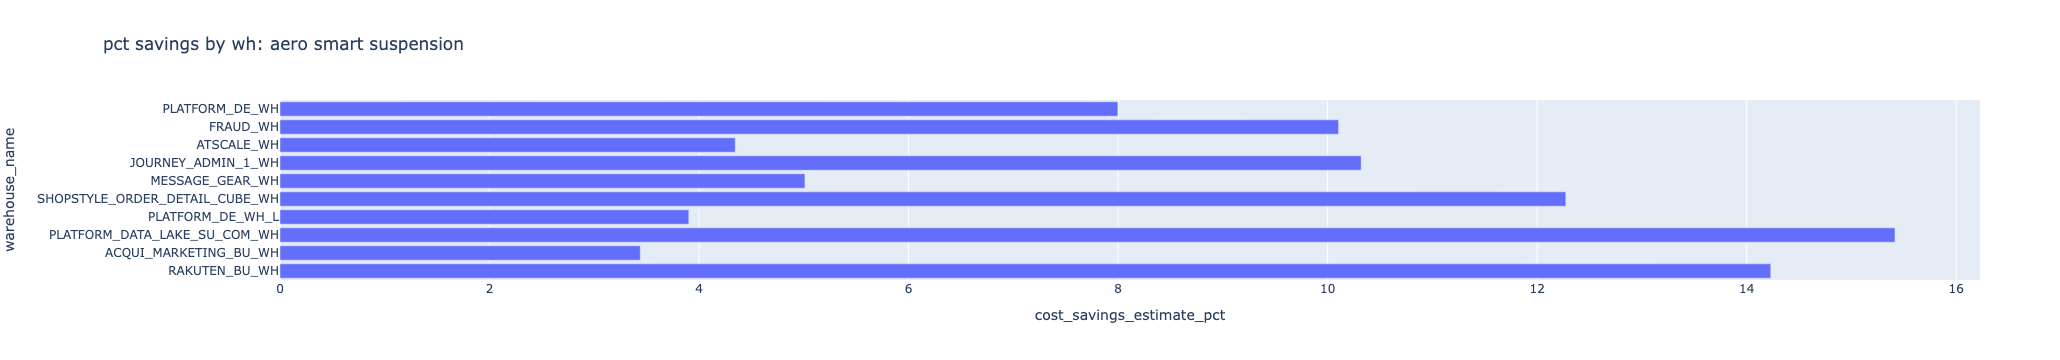

In [6]:
from IPython.display import display
import plotly.express as px

sql = """
with a as (

select 
    * exclude dollars_used_idle
from warehouse_profile
)
select
    *,
    case when max_cluster_number = 1 then 0 else dollars_used_compute - dollars_used_single_cluster_inferred end as dollars_used_addtl_clusters_inferred,
    (dollars_used_compute - dollars_used_addtl_clusters_inferred) *pct_idle/100 as dollars_used_idle,
    dollars_used_compute - dollars_used_idle as dollars_used_active,
    dollars_used_idle * 0.2 as cost_savings_estimate,
    12 * cost_savings_estimate as cost_savings_estimate_annualized,
    100* cost_savings_estimate / dollars_used_compute as cost_savings_estimate_pct
from a
order by dollars_used_idle desc;
"""
df = sql_to_df(sql)
display(df.sort_values('dollars_used_compute'))
fig = px.bar(
    df.sort_values('dollars_used_idle', ascending=True).tail(10), 
    y="warehouse_name", 
    x=["dollars_used_idle", 'dollars_used_active'], 
    # color = 'wh_utilization_status', 
    # color_discrete_sequence=['blue', 'green', 'red'],
    title = "idle spend",
    orientation='h',
    height=100
)

fig.update_layout(
    xaxis={'side': 'top'}, 
    xaxis_title="dollars"
)
fig.show()

fig = px.bar(
    df.sort_values('dollars_used_idle', ascending=True).tail(10), 
    y="warehouse_name", 
    x='cost_savings_estimate_annualized', 
    # color = 'wh_utilization_status', 
    # color_discrete_sequence=['blue', 'green', 'red'],
    title = "annualized savings by wh: aero smart suspension",
    orientation='h',
    height=100
)

fig.show()
# fig.update_layout(
#     xaxis={'side': 'top'}, 
#     xaxis_title="dollars"
# )
fig = px.bar(
    df.sort_values('dollars_used_idle', ascending=True).tail(10), 
    y="warehouse_name", 
    x='cost_savings_estimate_pct', 
    # color = 'wh_utilization_status', 
    # color_discrete_sequence=['blue', 'green', 'red'],
    title = "pct savings by wh: aero smart suspension",
    orientation='h',
    height=100
)
fig.show()

# fig.update_layout(
#     xaxis={'side': 'top'}, 
#     xaxis_title="dollars"
# )

# fig = px.bar(
#     df.sort_values('pct_idle', ascending=True), 
#     y="warehouse_name", 
#     x='pct_idle', 
#     # color = 'wh_utilization_status', 
#     # color_discrete_sequence=['blue', 'green', 'red'],
#     title = "pct_idle",
#     orientation='h',
#     height=2000
# )
# fig.show()

In [36]:
%%markdown
# Idle Time Deep Dive (WIP)

# Idle Time Deep Dive (WIP)


RUNNING pre-hook: []
using arrow to fetch results...


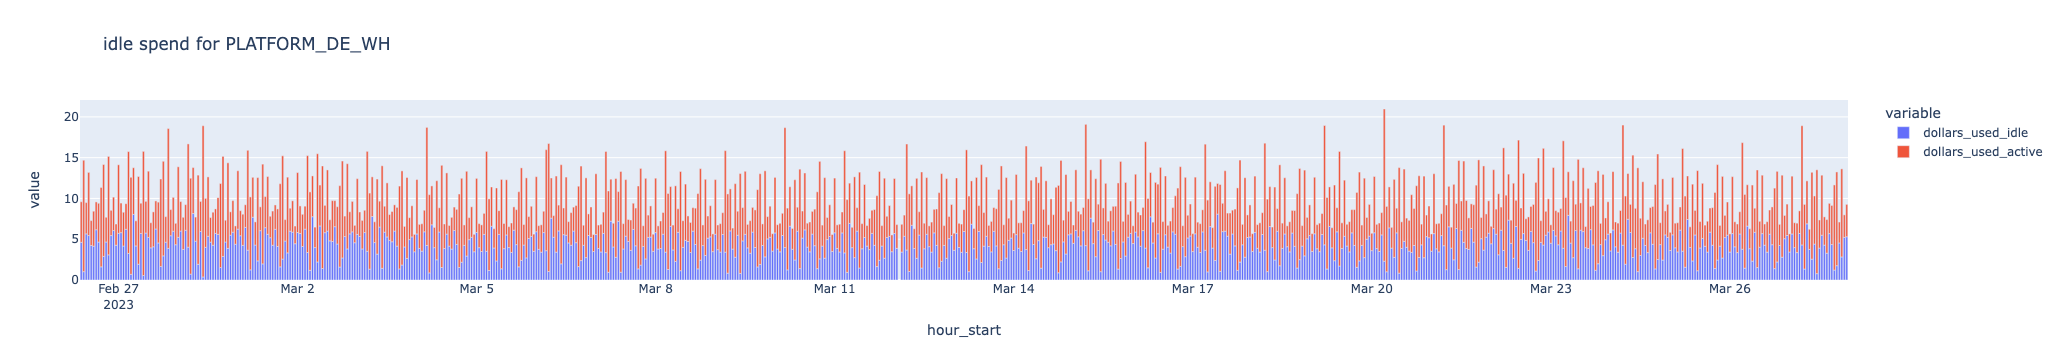

In [37]:
sql = """
select 
    * exclude dollars_used_idle, 
    case when max_cluster_number = 1 then 0 else dollars_used_compute - dollars_used_single_cluster_inferred end as dollars_used_addtl_clusters_inferred,
    (dollars_used_compute - dollars_used_addtl_clusters_inferred) *pct_idle/100 as dollars_used_idle,
    dollars_used_compute - dollars_used_idle as dollars_used_active,
    dollars_used_idle * 0.2 as cost_savings_estimate,
    div0(100* cost_savings_estimate, dollars_used_compute) as cost_savings_estimate_pct
from warehouse_profile_by_hour
order by cost_savings_estimate desc;
"""
df = sql_to_df(sql)
df = df[df.warehouse_name == 'PLATFORM_DE_WH']

fig = px.bar(
    df, 
    x="hour_start", 
    y=["dollars_used_idle", 'dollars_used_active'], 
    # color = 'wh_utilization_status', 
    # color_discrete_sequence=['blue', 'green', 'red'],
    title = "idle spend for PLATFORM_DE_WH",
    # orientation='h',
    # height=100
)
fig.show()

In [25]:
%%markdown
## --> some warehouses have significant idle time. This could be cut with more aggressive shutdowns and/or packing workloads onto fewer warehouses.

## --> some warehouses have significant idle time. This could be cut with more aggressive shutdowns and/or packing workloads onto fewer warehouses.


In [39]:
%%markdown
# Warehouse Resource Utilization
### Search for warehouses with queries that could be run on a smaller warehouse
### This would motivate resizing the warehouse or moving those queries to a smaller warehouse.

# Warehouse Resource Utilization
### Search for warehouses with queries that could be run on a smaller warehouse
### This would motivate resizing the warehouse or moving those queries to a smaller warehouse.


RUNNING pre-hook: []
using arrow to fetch results...


['MESSAGE_GEAR_WH',
 'PLATFORM_DE_WH',
 'PLATFORM_DATA_LAKE_SU_JP_WH',
 'PLATFORM_DATA_LAKE_SU_CA_WH',
 'SHOPSTYLE_ORDER_DETAIL_CUBE_WH',
 'EBATES_COM_REALTIME_DE_WH',
 'SINGULAR_WH',
 'ATSCALE_WH',
 'FRAUD_WH',
 'JOURNEY_ADMIN_1_WH']

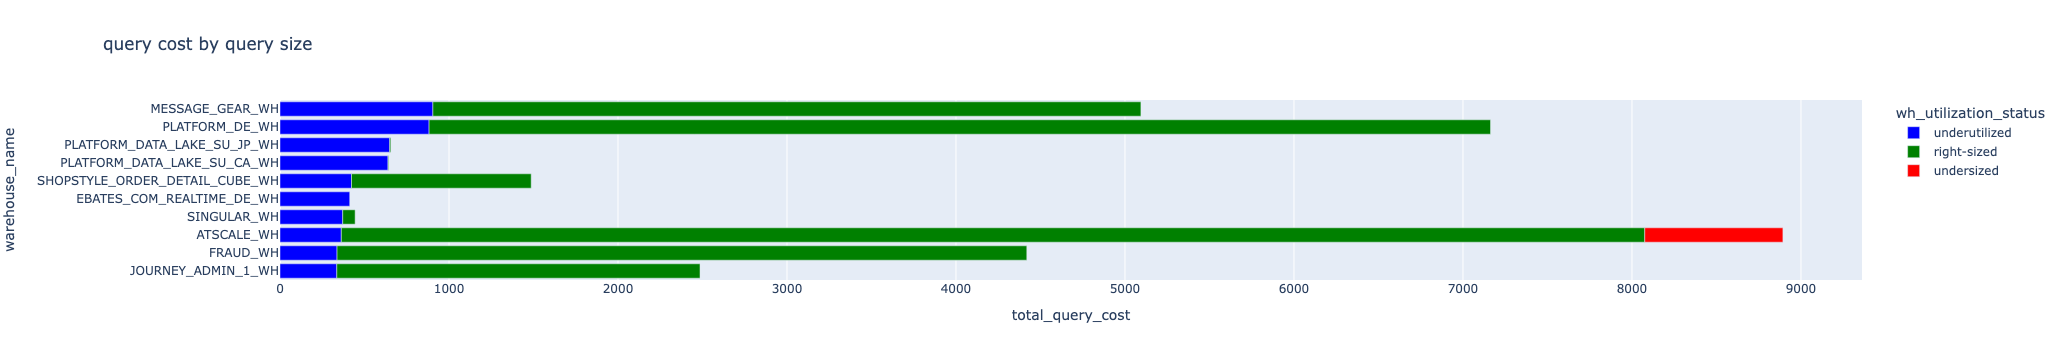

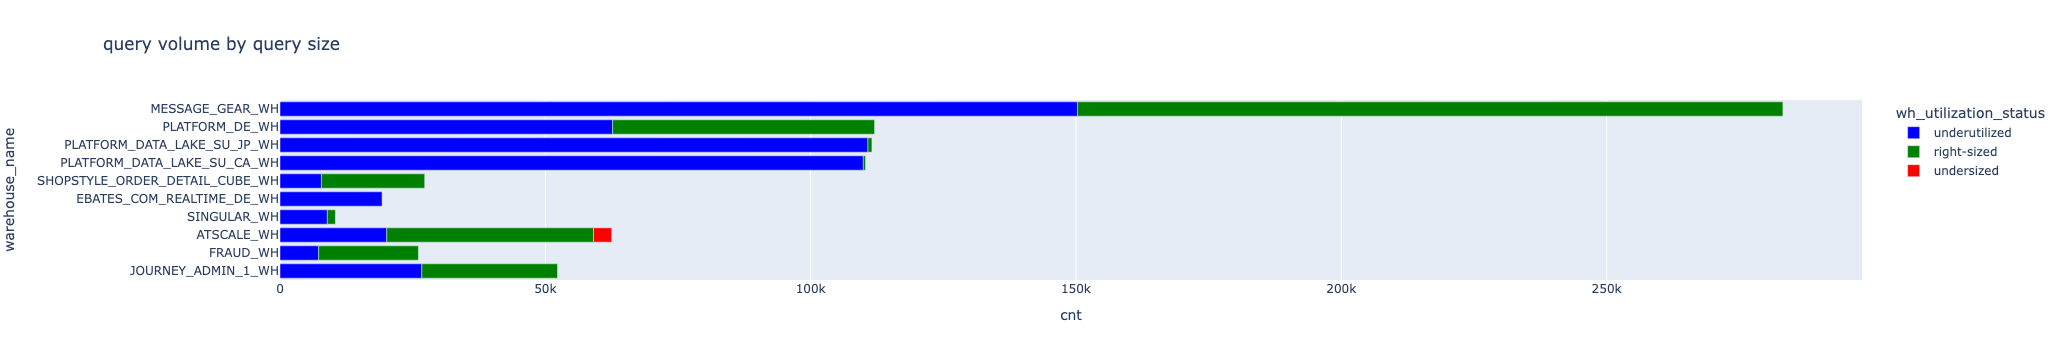

/var/folders/_8/8l7g_4kn4rb7glybx2qt73440000gn/T/ipykernel_71883/2632679090.py:57: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



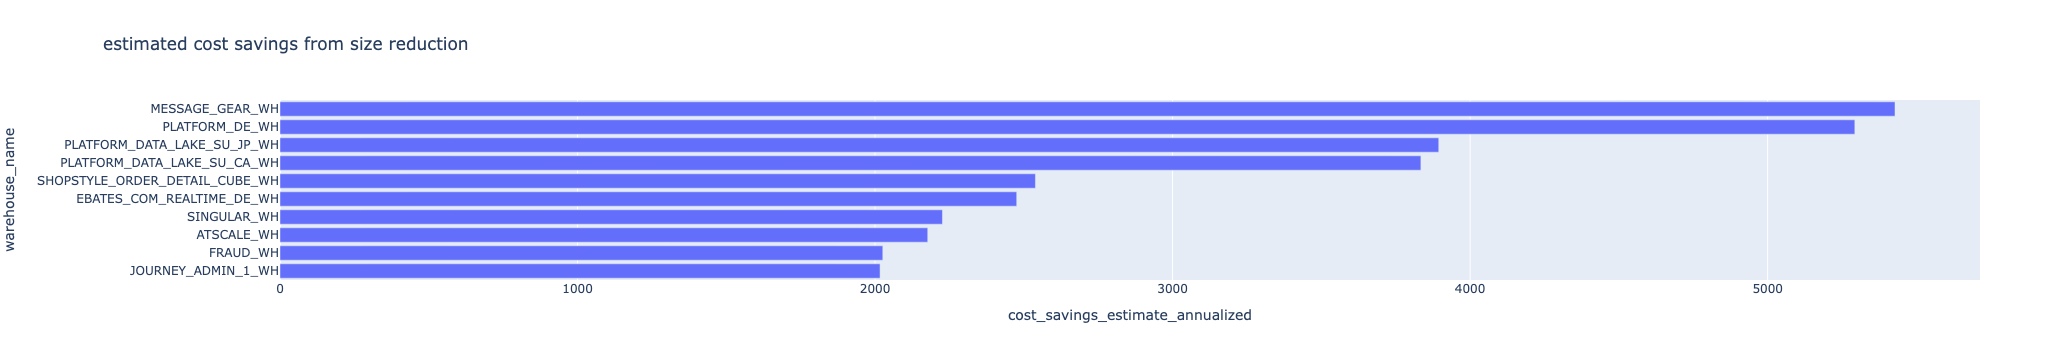

In [12]:
from IPython.display import display

sql = """
with a as (
select
    warehouse_name,
    wh_utilization_status,
    (case when wh_utilization_status = 'underutilized' then 0 
when wh_utilization_status = 'right-sized' then 1 
else 2 end) as status_id,
    count(*) cnt,
    sum(query_cost) total_query_cost
from query_history_narrowed
group by 
    warehouse_name,
    wh_utilization_status
)
select 
    *,
        first_value(total_query_cost) over (partition by warehouse_name order by status_id) as underutilized_cost,
    case when status_id = 0 then 0.5 * total_query_cost end as cost_savings_estimate,
    cost_savings_estimate * 12 as cost_savings_estimate_annualized
from a
order by underutilized_cost asc, warehouse_name, status_id
"""

df = sql_to_df(sql)

topten = df[df.status_id == 0].sort_values('total_query_cost', ascending=False).head(10).warehouse_name.tolist()
display(topten)
# display(df)
fig = px.bar(
    df[df.warehouse_name.isin(topten)], 
    y="warehouse_name", 
    x="total_query_cost", 
    color = 'wh_utilization_status', 
    color_discrete_sequence=['blue', 'green', 'red'],
    title = "query cost by query size",
    orientation='h',
    height=100
)
fig.show()

fig = px.bar(
    df[df.warehouse_name.isin(topten)], 
    y="warehouse_name", 
    x="cnt", 
    color = 'wh_utilization_status', 
    color_discrete_sequence=['blue', 'green', 'red'],
    title = "query volume by query size",
    orientation='h',
    height=100
)
fig.show()


fig = px.bar(
    df[df.warehouse_name.isin(topten)][df.status_id == 0], 
    y="warehouse_name", 
    x="cost_savings_estimate_annualized", 
    # color = 'wh_utilization_status', 
    # color_discrete_sequence=['blue', 'green', 'red'],
    title = "estimated cost savings from size reduction",
    orientation='h',
    height=100
)
fig.show()


fig = px.bar(
    df[df.warehouse_name.isin(topten)][df.status_id == 0], 
    y="warehouse_name", 
    x="cost_savings_estimate_annualized", 
    # color = 'wh_utilization_status', 
    # color_discrete_sequence=['blue', 'green', 'red'],
    title = "estimated cost savings from size reduction",
    orientation='h',
    height=100
)
fig.show()


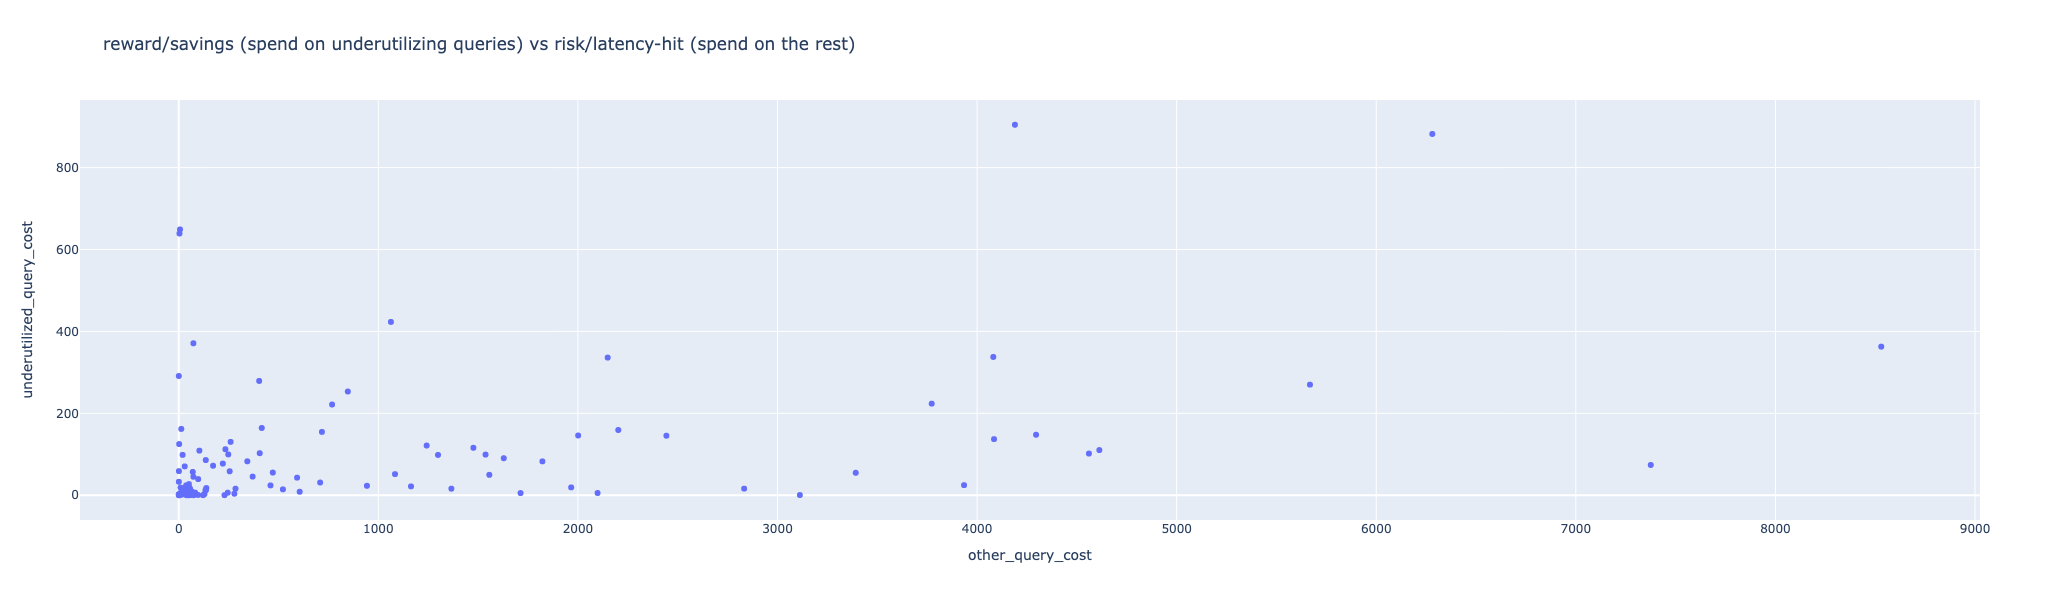

In [21]:


sql = """
with a as (
select
    warehouse_name,
    wh_utilization_status,
    (case when wh_utilization_status = 'underutilized' then 0 
when wh_utilization_status = 'right-sized' then 1 
else 2 end) as status_id,
    count(*) cnt,
    sum(query_cost) total_query_cost
from query_history_narrowed
group by 
    warehouse_name,
    wh_utilization_status
)
select 
    warehouse_name,
    max(case when status_id = 0 then total_query_cost end) as underutilized_query_cost,
    sum(case when status_id != 0 then total_query_cost end) as other_query_cost
from a
group by 1
order by 2 desc nulls last;
"""

df = sql_to_df(sql)

fig = px.scatter(
    df, 
    x="other_query_cost", 
    y='underutilized_query_cost', 
    # color = 'wh_utilization_status', 
    # color_discrete_sequence=['blue', 'green', 'red'],
    title = "reward/savings (spend on underutilizing queries) vs risk/latency-hit (spend on the rest)",
    hover_data=['warehouse_name'],
    # orientation='h',
    height=600
)
fig.show()

In [20]:
%%markdown
## Warehouses to the top and left are low hanging fruit; reduce their size ASAP. 
## Warheouses at the top and further right would also benefit from size reduction, but costreduction will come with a latency hit!

## Warehouses to the top and left are low hanging fruit; reduce their size ASAP. 
## Warheouses at the top and further right would also benefit from size reduction, but costreduction will come with a latency hit!


In [31]:
%%markdown
# SCRATCH
---------

# SCRATCH
---------


In [3]:
sql = """
with underutilizing_query_cost as (
    select
        warehouse_id,
        warehouse_name,
        -- wh_utilization_status,
        count(*) cnt,
        sum(query_cost) total_query_cost
    from query_history_narrowed
    where wh_utilization_status = 'underutilized'
    group by 
        warehouse_id, warehouse_name
),
idle_cost as (
    select 
        * exclude credits_used_idle, 
        case when max_cluster_number = 1 then 0 else credits_used_compute - credits_used_inferred end as credits_used_addtl_clusters,
        (credits_used_compute - credits_used_addtl_clusters) *pct_idle/100 as credits_used_idle,
        credits_used_compute - credits_used_idle as credits_used_active
    from warehouse_profile
    -- order by credits_used_idle desc
),
wh_load as (
    select 
        warehouse_id,
        warehouse_name,
        avg(avg_running) avg_running,
        avg(avg_queued_load) avg_queued_load,
        median(avg_queued_load) median_queued_load
    from 
        stg_warehouse_load_history
    where start_time > (select min(start_time) from query_history_narrowed)
    group by 1,2
)
select 
    i.*,
    w.avg_running,
    w.avg_queued_load,
    median_queued_load,
    coalesce(u.cnt, 0) as cnt,
    coalesce(u.total_query_cost, 0) as underutilized_query_spend,
    
    credits_used_idle + underutilized_query_spend as estimated_waste_total,
    credits_used_idle*0.2 + underutilized_query_spend*0.5 as estimated_cost_savings,
    100*estimated_cost_savings/credits_used_compute as estimated_cost_savings_pct
from idle_cost i
full outer join underutilizing_query_cost  u
on i.warehouse_name = u.warehouse_name and i.warehouse_id = u.warehouse_id
left join wh_load w
on i.warehouse_name = w.warehouse_name and i.warehouse_id = w.warehouse_id
order by estimated_waste_total desc
;
"""

df = sql_to_df(sql, ['set lookback_days=30'])
df

RUNNING pre-hook: ['set lookback_days=30']
RUNNING SQL: 
with underutilizing_query_cost as (
    select
        warehouse_id,
        warehouse_name,
        -- wh_utilization_status,
        count(*) cnt,
        sum(query_cost) total_query_cost
    from query_history_narrowed
    where wh_utilization_status = 'underutilized'
    group by 
        warehouse_id, warehouse_name
),
idle_cost as (
    select 
        * exclude credits_used_idle, 
        case when max_cluster_number = 1 then 0 else credits_used_compute - credits_used_inferred end as credits_used_addtl_clusters,
        (credits_used_compute - credits_used_addtl_clusters) *pct_idle/100 as credits_used_idle,
        credits_used_compute - credits_used_idle as credits_used_active
    from warehouse_profile
    -- order by credits_used_idle desc
),
wh_load as (
    select 
        warehouse_id,
        warehouse_name,
        avg(avg_running) avg_running,
        avg(avg_queued_load) avg_queued_load,
        median(avg_queued

auto_suspend  warehouse_id                     warehouse_name  \
0             NaN            24                     PLATFORM_DE_WH   
1             NaN           123                    MESSAGE_GEAR_WH   
2             NaN            93                           FRAUD_WH   
3             NaN             7                         ATSCALE_WH   
4             NaN           173                 JOURNEY_ADMIN_1_WH   
..            ...           ...                                ...   
124           NaN           102                EBATES_CA_ODS_DE_WH   
125           NaN           185                    FOUNDATION_2_WH   
126           NaN           222  ENRICH_SCIENCE_ENGG_FORECAST_1_WH   
127           NaN           140                  SHOPSTYLE_CCPA_WH   
128           NaN             4                         TABLEAU_WH   

                   warehouse_sizes  max_cluster_number  active_hours  \
0                  [\n  "Large"\n]                   2    432.239032   
1                 [\n  "Medium"\n]                   5    347.321481   
2                  [\n  "Large"\n]                   2    245.466991   
3    [\n  "X-Large",\n  "Large"\n]                   5    175.805648   
4                 [\n  "Medium"\n]                   1    312.037087   
..                             ...                 ...           ...   
124              [\n  "X-Small"\n]                   1      0.068124   
125               [\n  "Medium"\n]                   1      0.034183   
126               [\n  "Medium"\n]                   1      0.041320   
127                [\n  "Large"\n]                   1      4.245361   
128               [\n  "Medium"\n]                   1      0.113943   

     idle_hours   pct_idle  credits_used_compute  credits_used_inferred  ...  \
0    180.661856  41.796747           3614.275278            3457.912256  ...   
1    160.825499  46.304507           2567.685556            1389.285924  ...   
2    140.664167  57.304718           2227.284722            1963.735924  ...   
3     72.912670  41.473451           4488.688056            2352.819711  ...   
4    161.012222  51.600348           1253.892778            1248.148349  ...   
..          ...        ...                   ...                    ...  ...   
124    0.067242  98.704577              0.068889               0.068124  ...   
125    0.016856  49.310894              0.137778               0.136731  ...   
126    0.016890  40.875417              0.165556               0.165280  ...   
127   -0.064288  -1.514306             33.975556              33.962889  ...   
128   -0.059200 -51.955777              0.456667               0.455772  ...   

     credits_used_idle  credits_used_active     avg_running  avg_queued_load  \
0          1445.294851          2126.849235  0.586778260227   0.000039952956   
1           643.301997          1396.952978  1.019972128277   0.031342631714   
2          1125.313336          1010.909485  0.368569197523   0.000076062826   
3           975.795542          2968.820925  1.540342674135   0.032408436978   
4           647.013033           606.246584  0.260695623842   0.036287286421   
..                 ...                  ...             ...              ...   
124           0.067996             0.000892  0.005763333250            0E-12   
125           0.067939             0.069838  0.214130000000            0E-12   
126           0.067672             0.097884  0.043944999875            0E-12   
127          -0.514494            34.472974  0.803699227058            0E-12   
128          -0.237265             0.693931  1.039943333000            0E-12   

    median_queued_load     cnt  underutilized_query_spend  \
0              0.00000   62676                 882.181814   
1              0.00079  150297                 904.676530   
2              0.00000    7283                 337.666475   
3              0.00000   20119                 362.842830   
4              0.00000   26706                 336.137469   
..         

RUNNING pre-hook: ['set lookback_days=30']
RUNNING SQL: 
with qhe as (
select 
    *    
from
    qhe_lookback
),
stats as (
select
    warehouse_name,
    date_trunc('day', execution_start_time) date,
    wh_utilization_status,
    count(*) cnt,
    sum(query_cost) total_query_cost
from qhe
group by 
    warehouse_name,date,
    wh_utilization_status
),
wh_utilization_by_date as (
select 
    *,
    100*ratio_to_report(cnt) over (partition by warehouse_name, date) as pct_cnt,
    100*ratio_to_report(total_query_cost) over (partition by warehouse_name, date) as pct_total_query_cost
from stats
)
select * from wh_utilization_by_date
order by warehouse_name, 
(case when wh_utilization_status = 'underutilized' then 0 
when wh_utilization_status = 'right-sized' then 1 
else 2 end) asc

using arrow to fetch results...


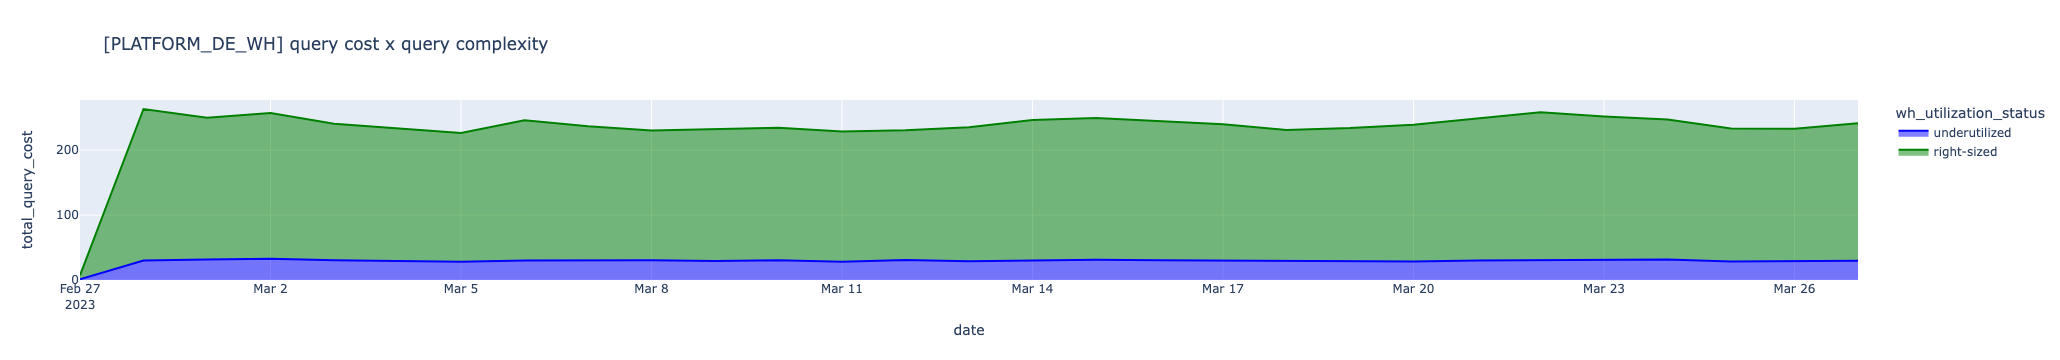

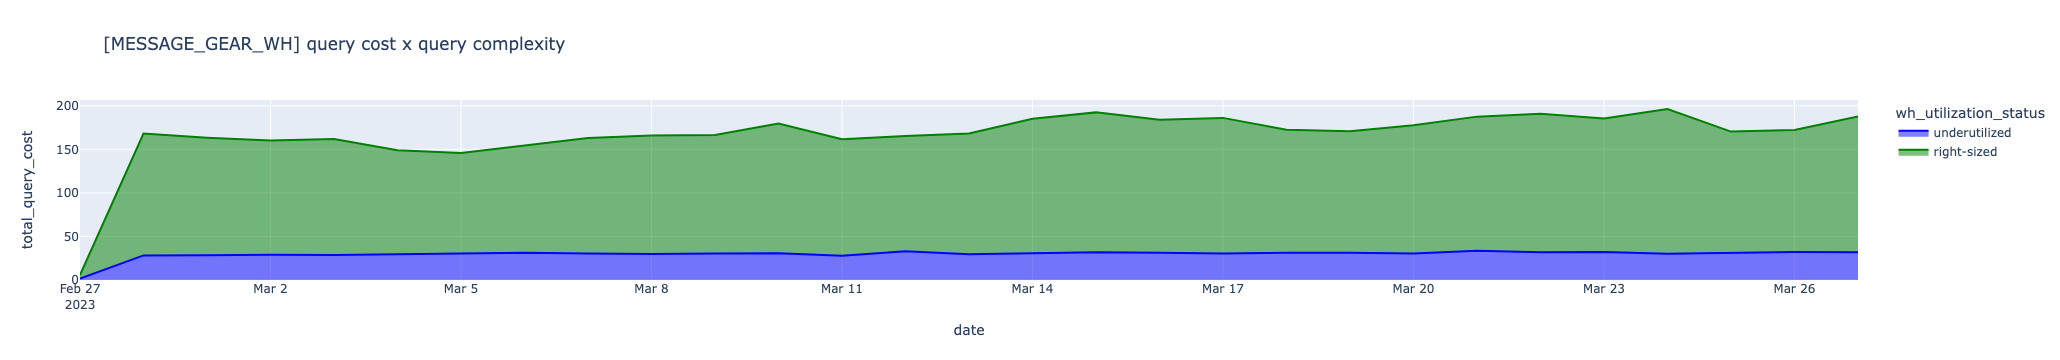

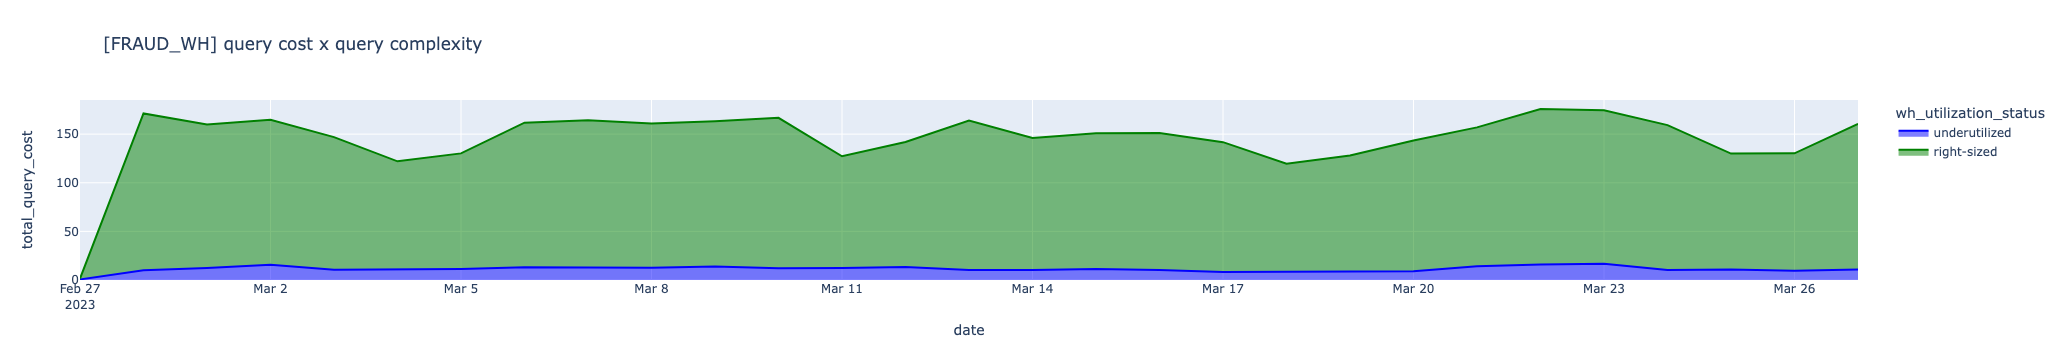

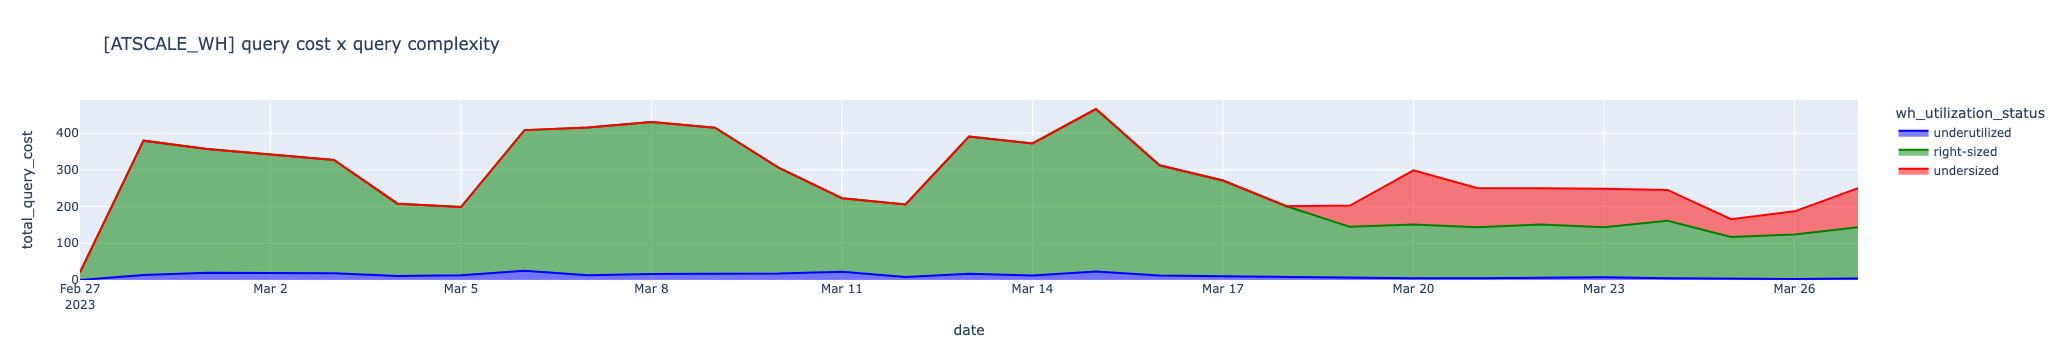

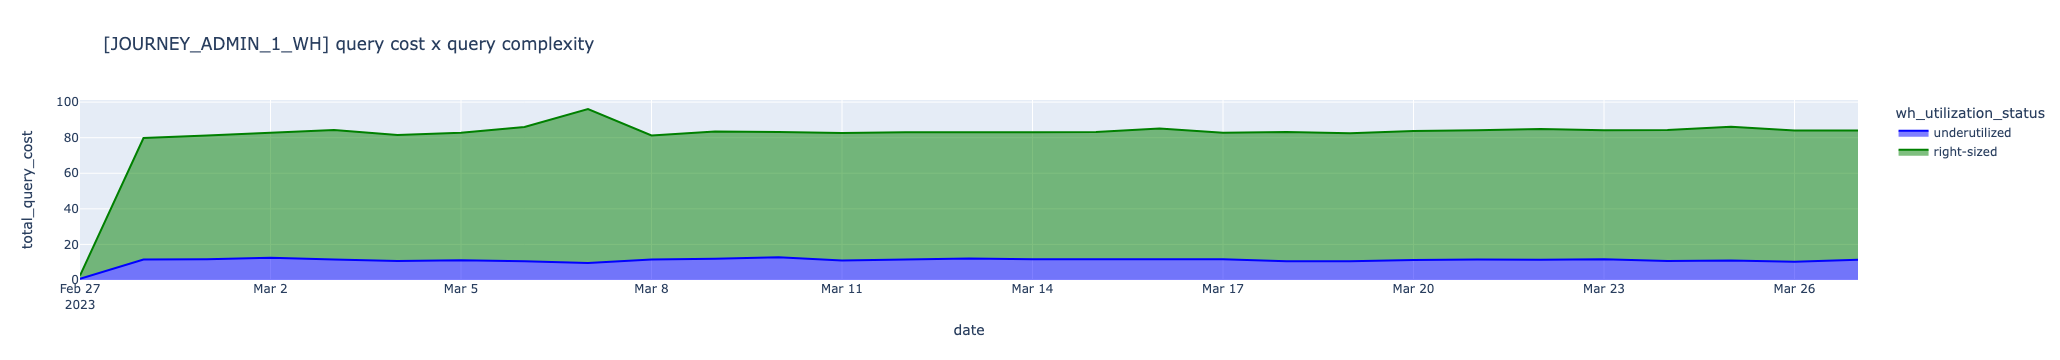

In [6]:
sql = """
with qhe as (
select 
    *    
from
    qhe_lookback
),
stats as (
select
    warehouse_name,
    date_trunc('day', execution_start_time) date,
    wh_utilization_status,
    count(*) cnt,
    sum(query_cost) total_query_cost
from qhe
group by 
    warehouse_name,date,
    wh_utilization_status
),
wh_utilization_by_date as (
select 
    *,
    100*ratio_to_report(cnt) over (partition by warehouse_name, date) as pct_cnt,
    100*ratio_to_report(total_query_cost) over (partition by warehouse_name, date) as pct_total_query_cost
from stats
)
select * from wh_utilization_by_date
order by warehouse_name, 
(case when wh_utilization_status = 'underutilized' then 0 
when wh_utilization_status = 'right-sized' then 1 
else 2 end) asc
"""
df = sql_to_df(sql, ['set lookback_days=30'])
import plotly.express as px

for wh in candidates:
    fig = px.area(
        df[df.warehouse_name == wh], 
        x="date", 
        y="total_query_cost", 
        color = 'wh_utilization_status', 
        color_discrete_sequence=['blue', 'green', 'red'],
        title = f"[{wh}] query cost x query complexity"
    )
    fig.update_layout(hovermode="x")
    fig.show()

    # fig = px.area(
    #     df[df.warehouse_name == wh], 
    #     x="date", 
    #     y="cnt", 
    #     color = 'wh_utilization_status', 
    #     color_discrete_sequence=['blue', 'green', 'red'],
    #     title = "query count"
    # )
    # fig.update_layout(hovermode="x")
    # fig.show()

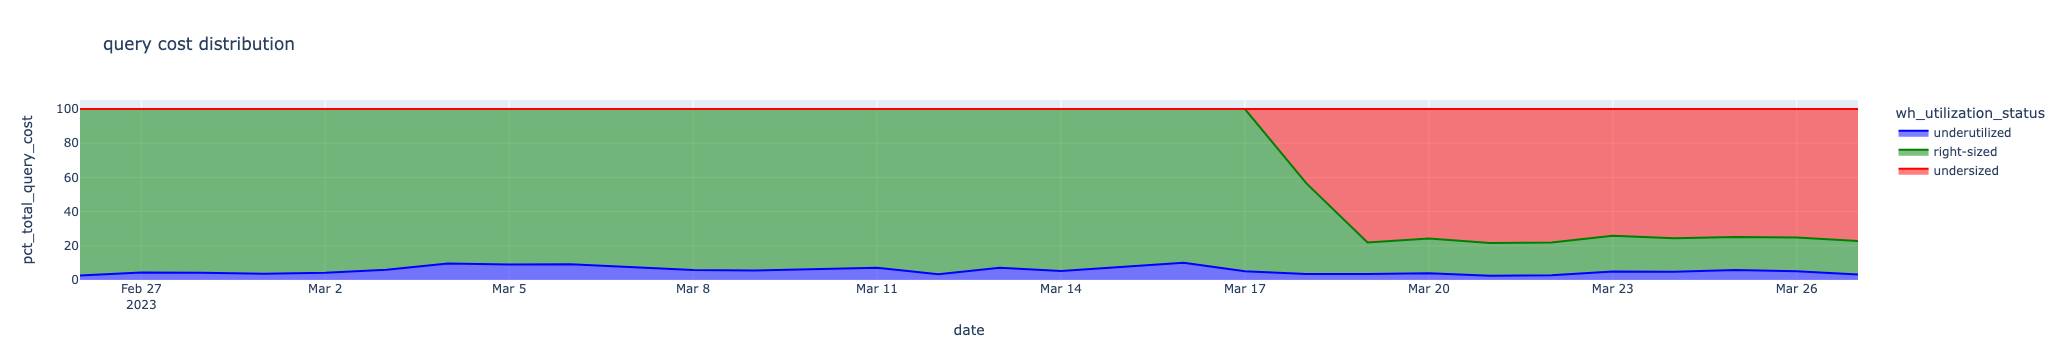

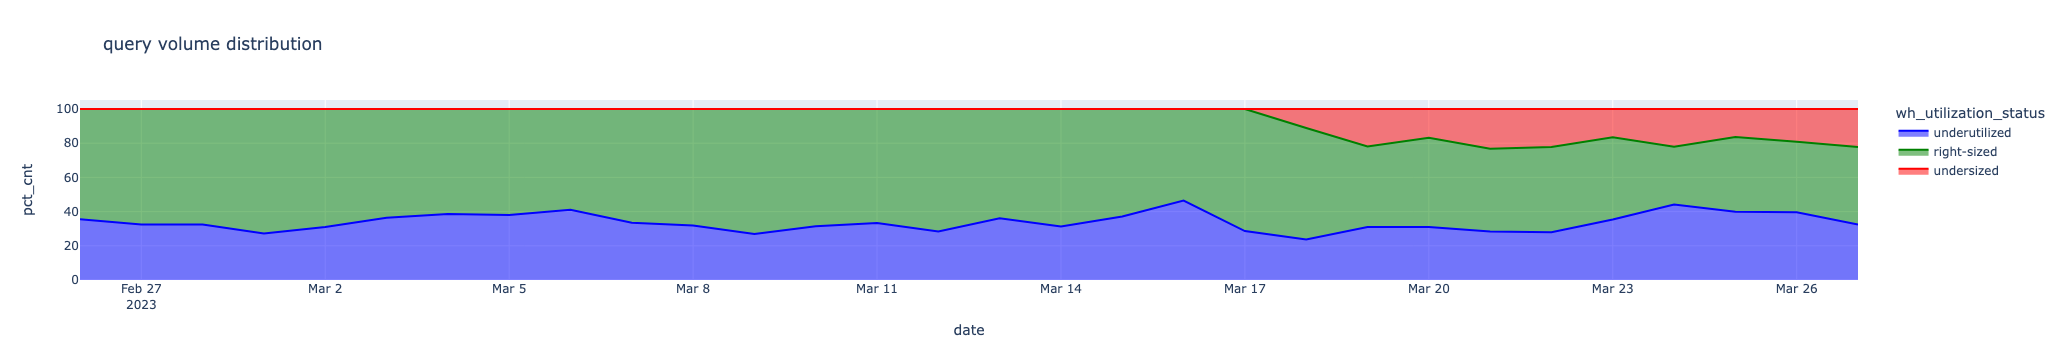

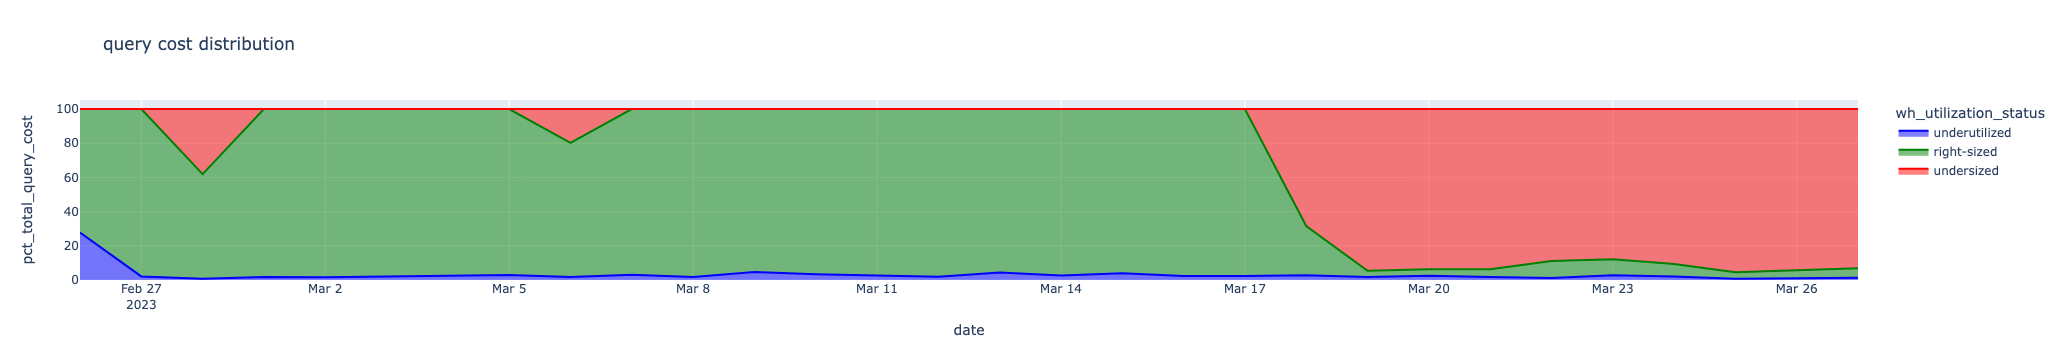

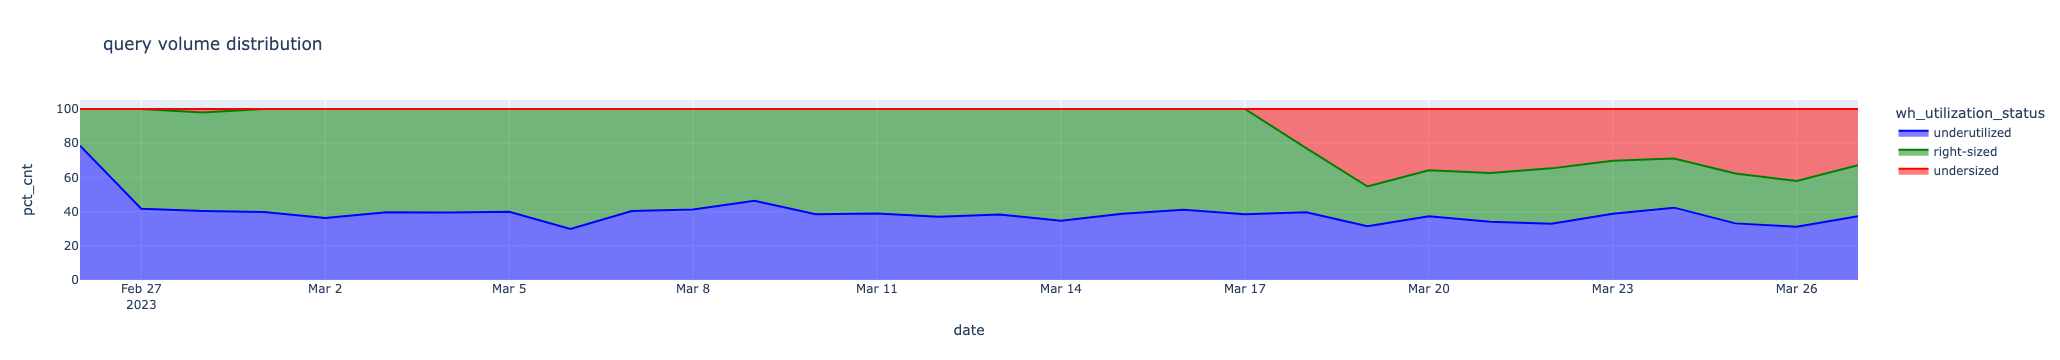

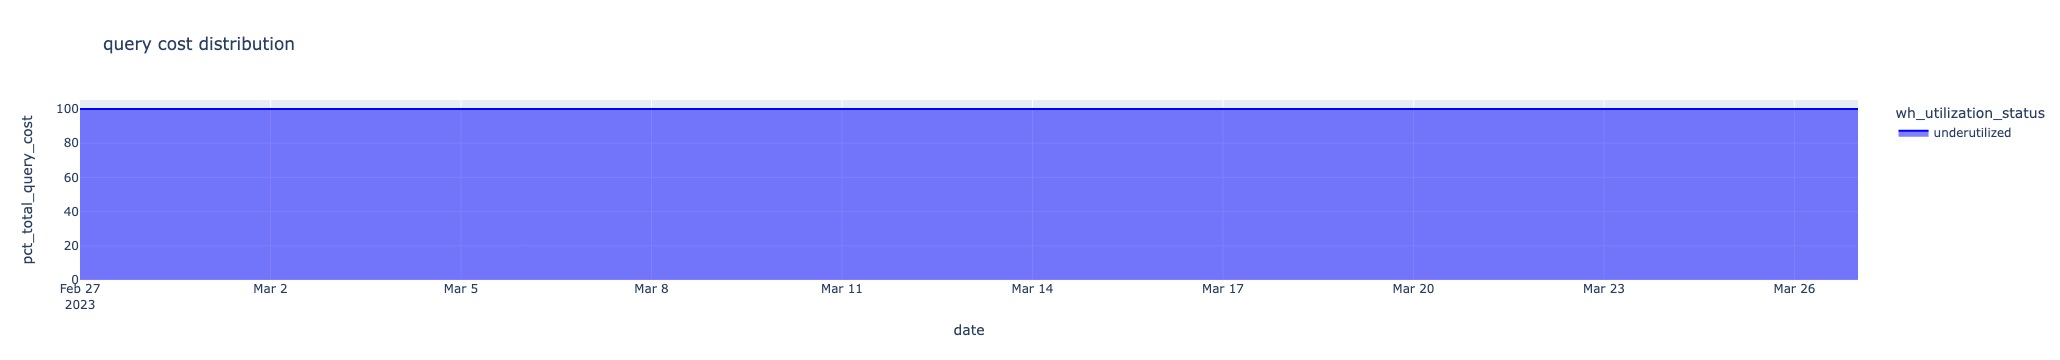

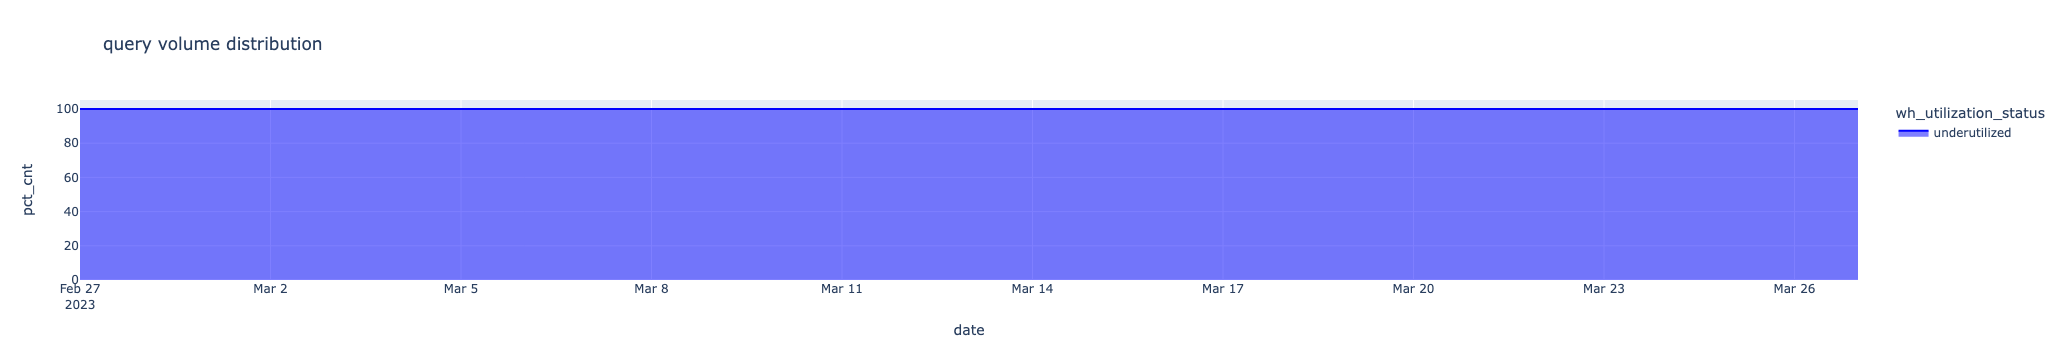

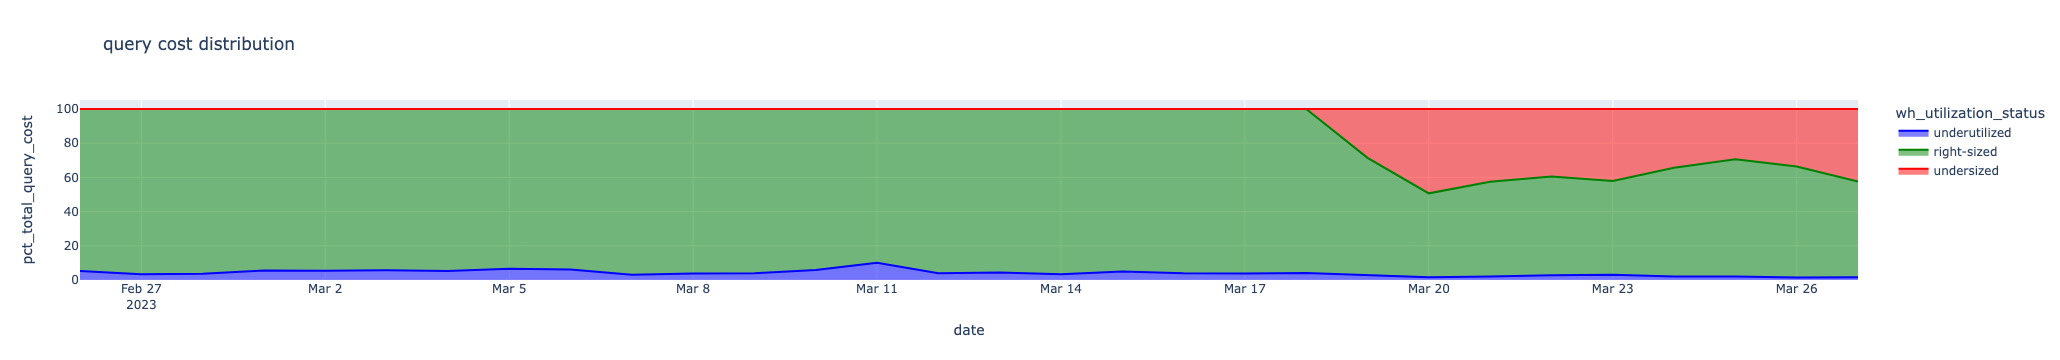

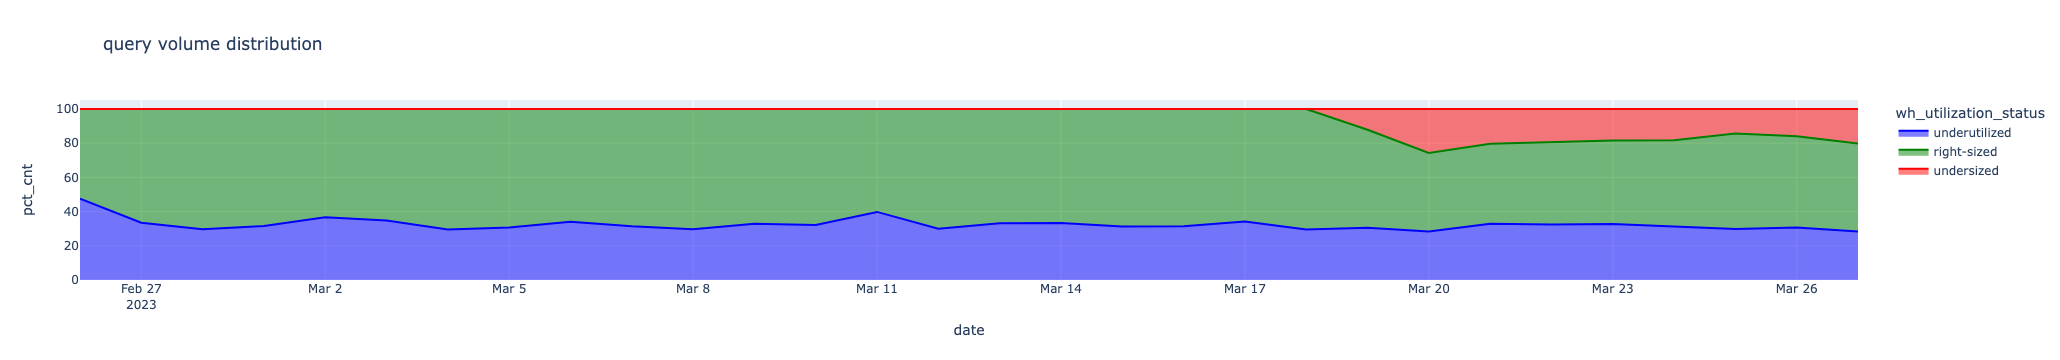

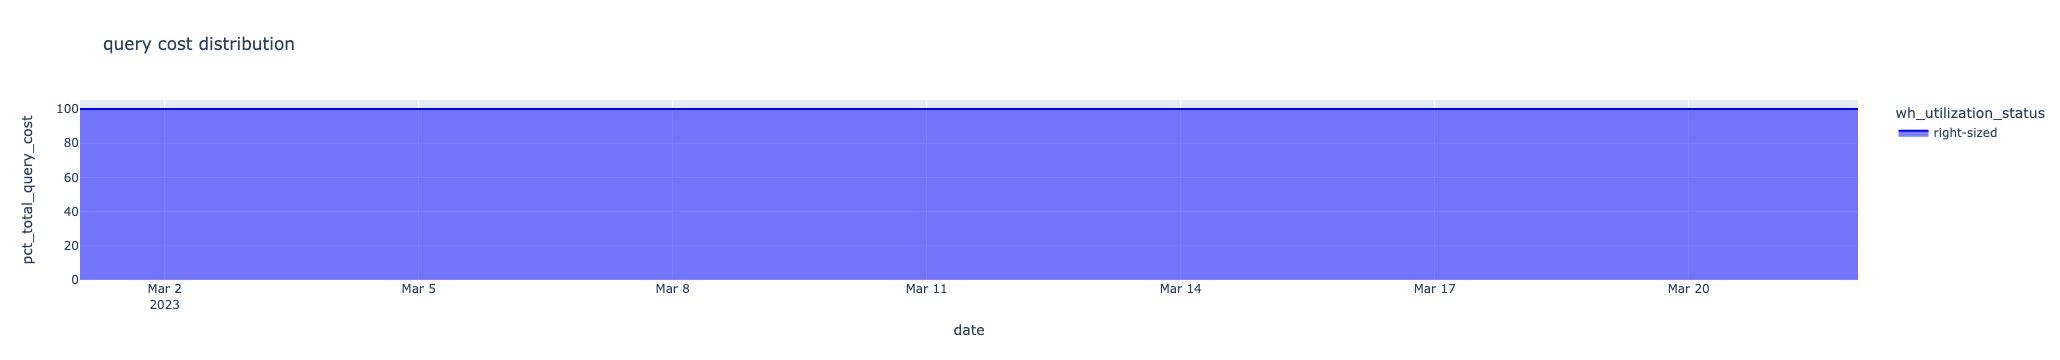

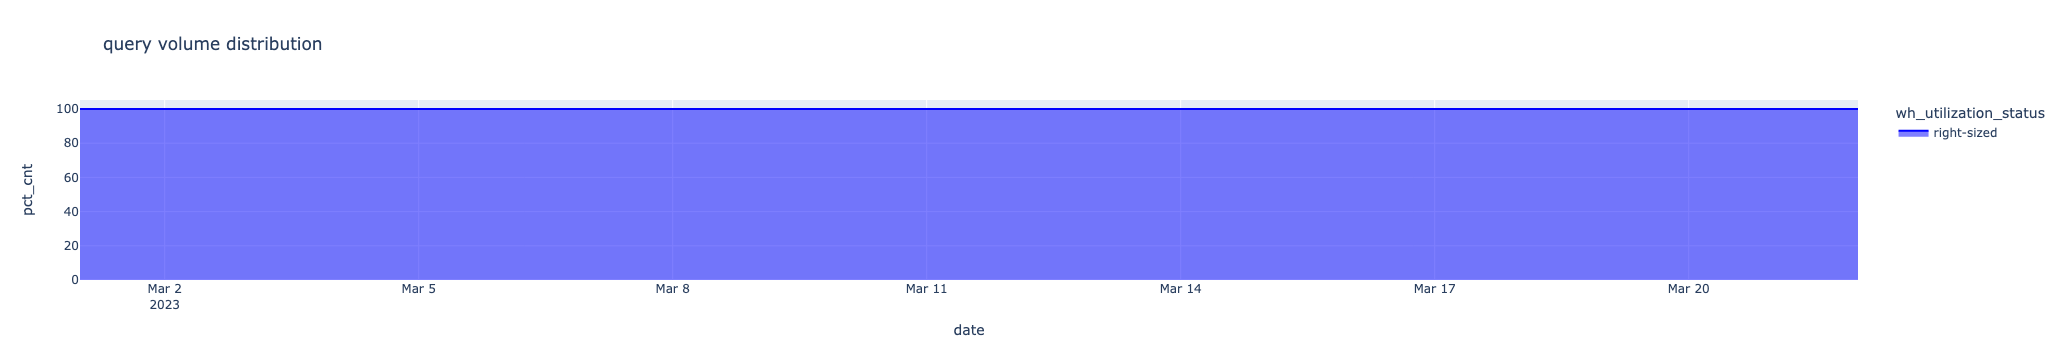

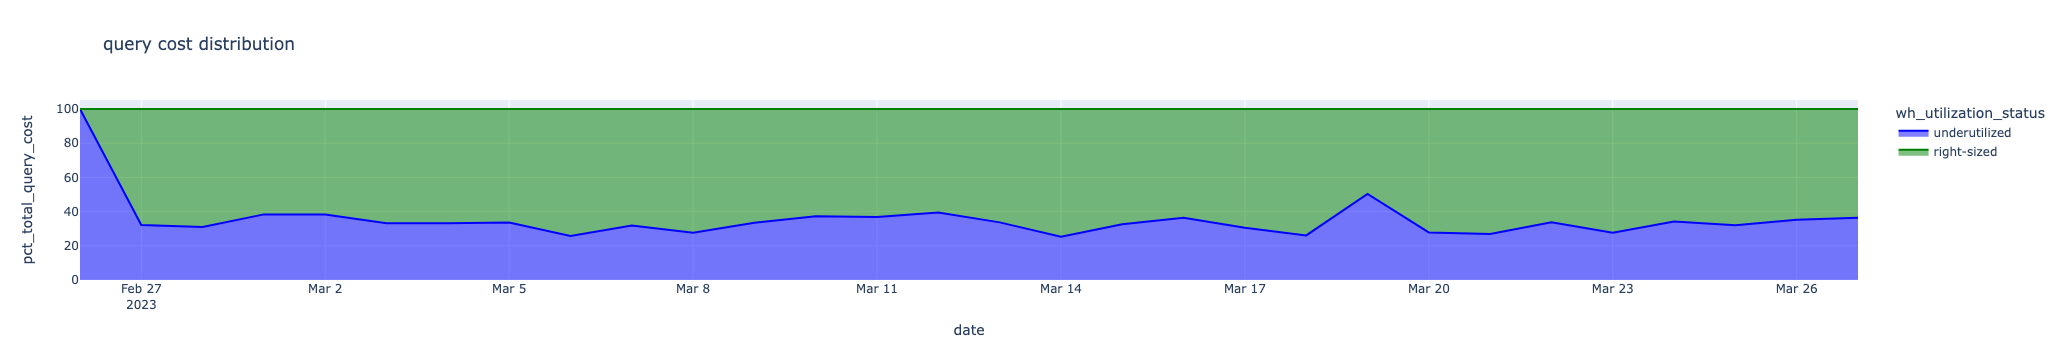

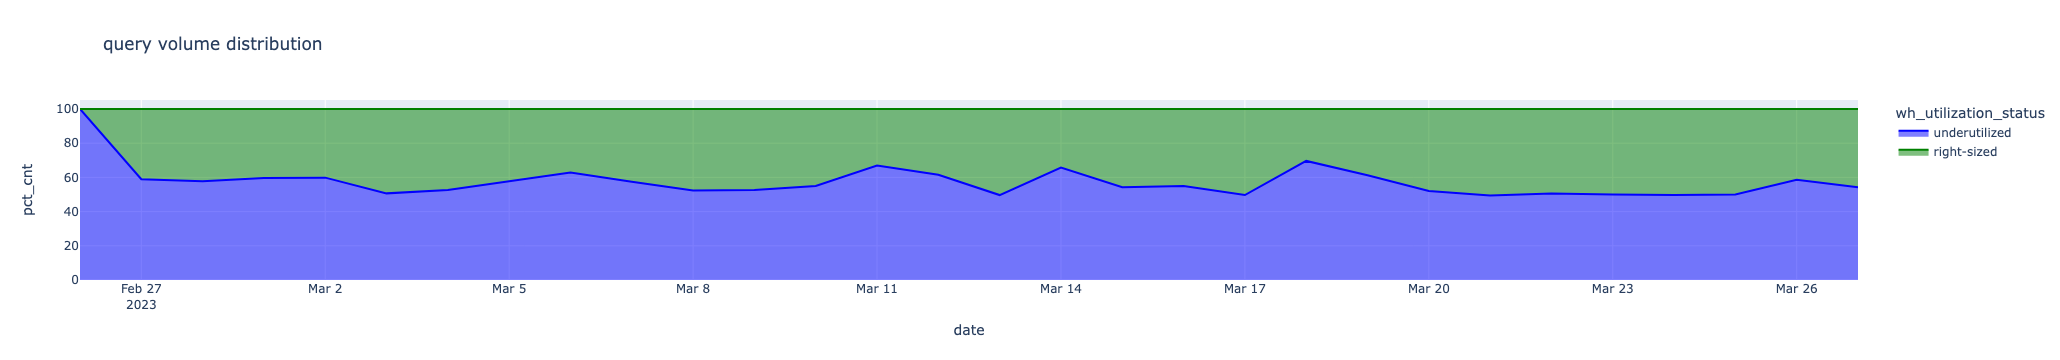

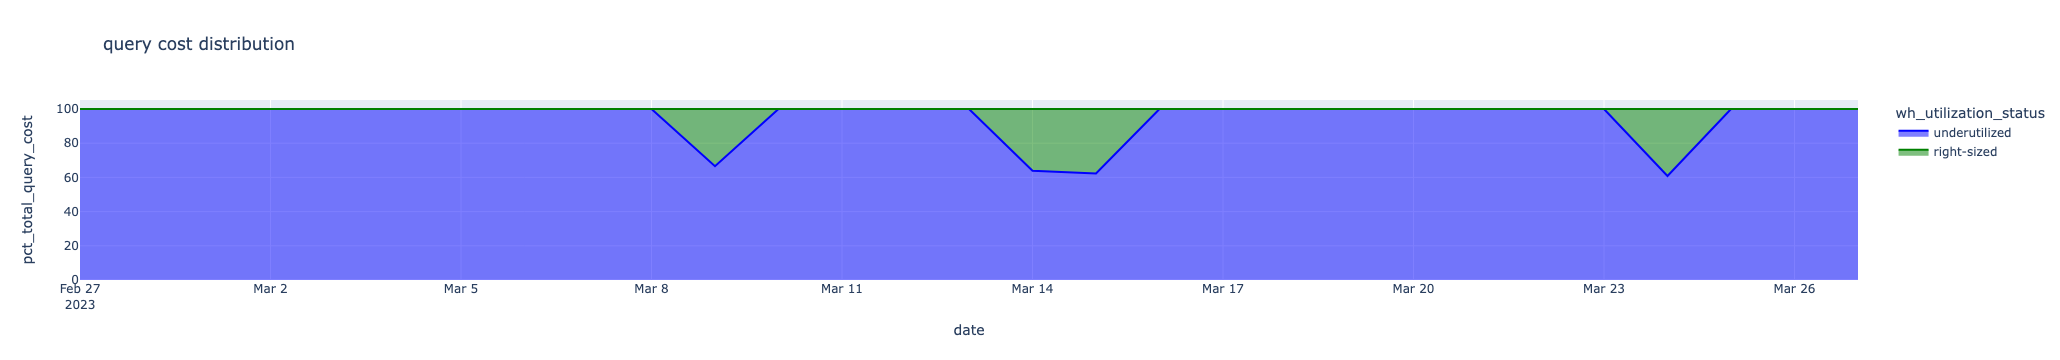

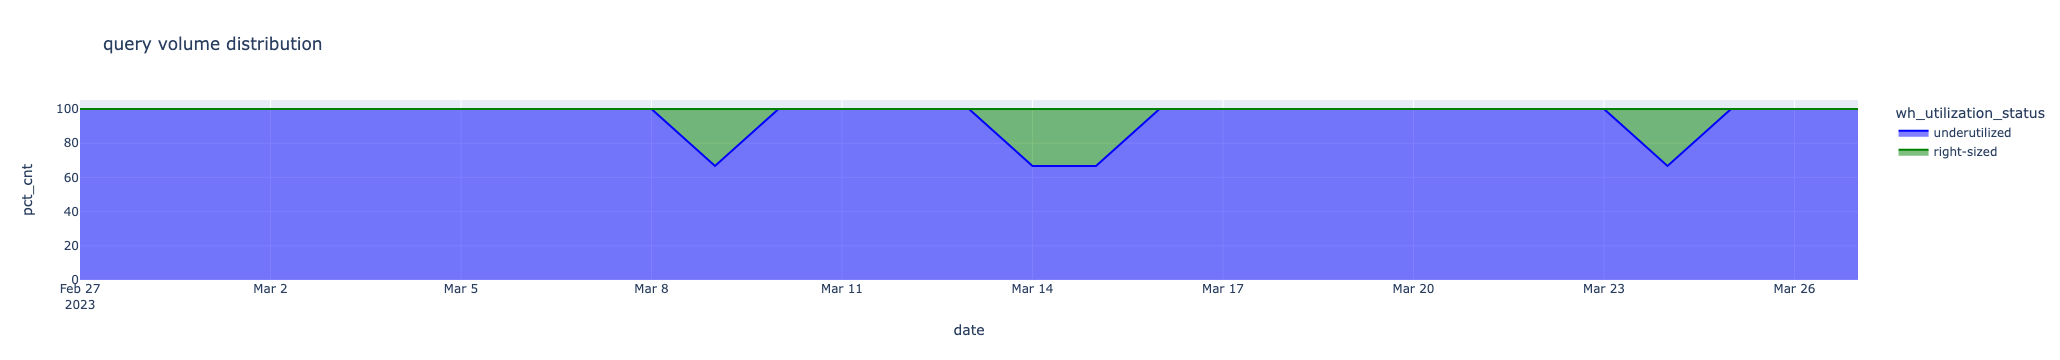

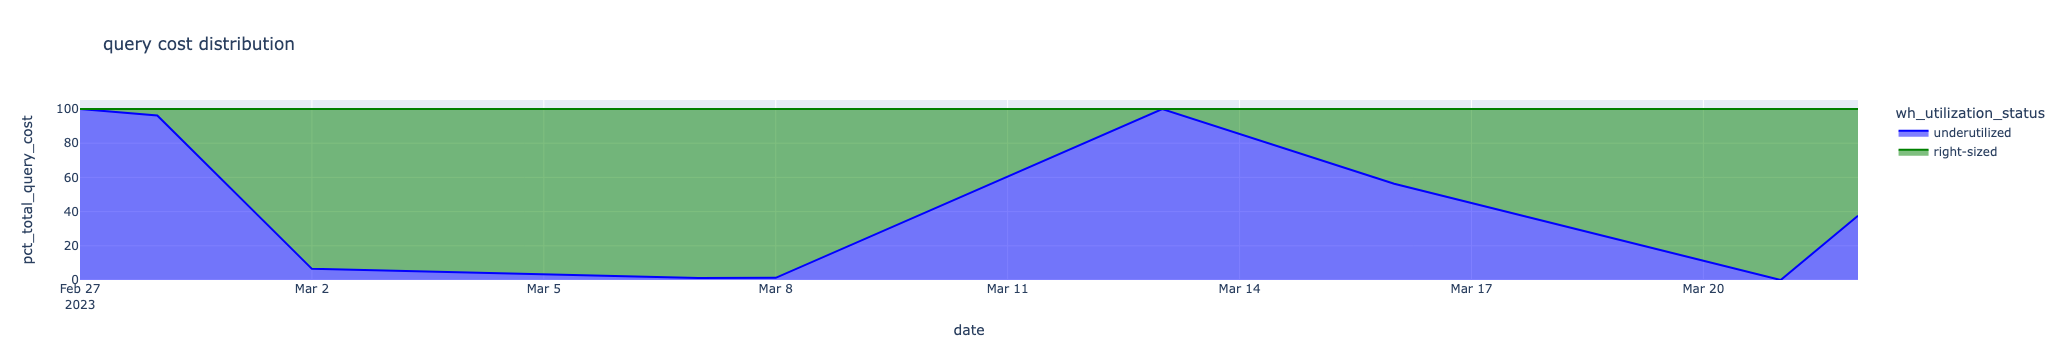

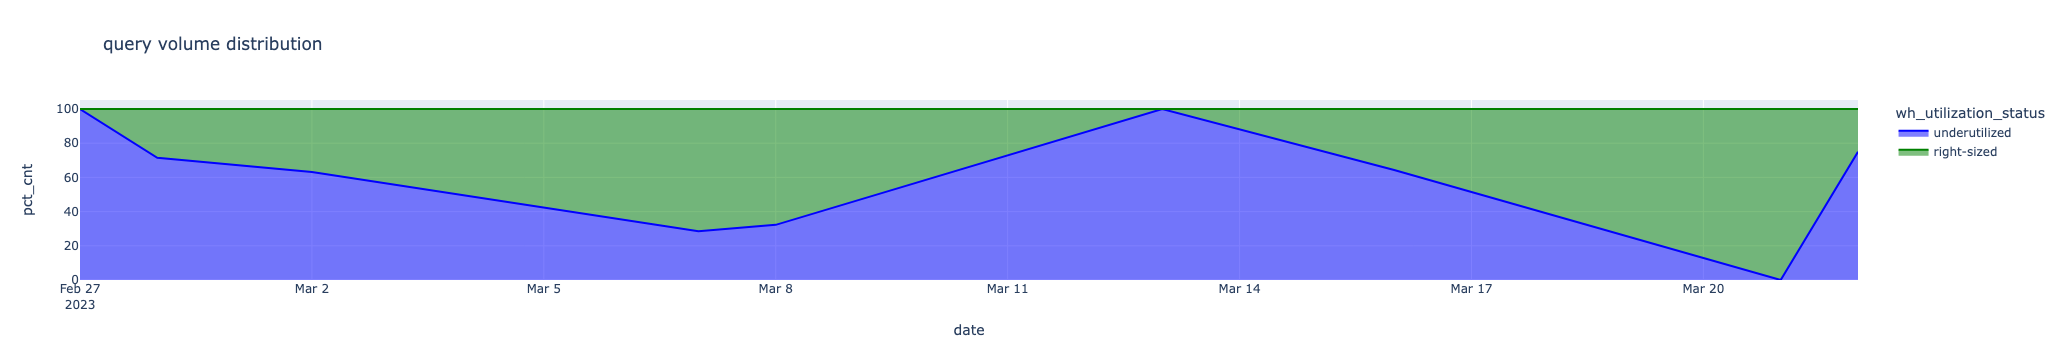

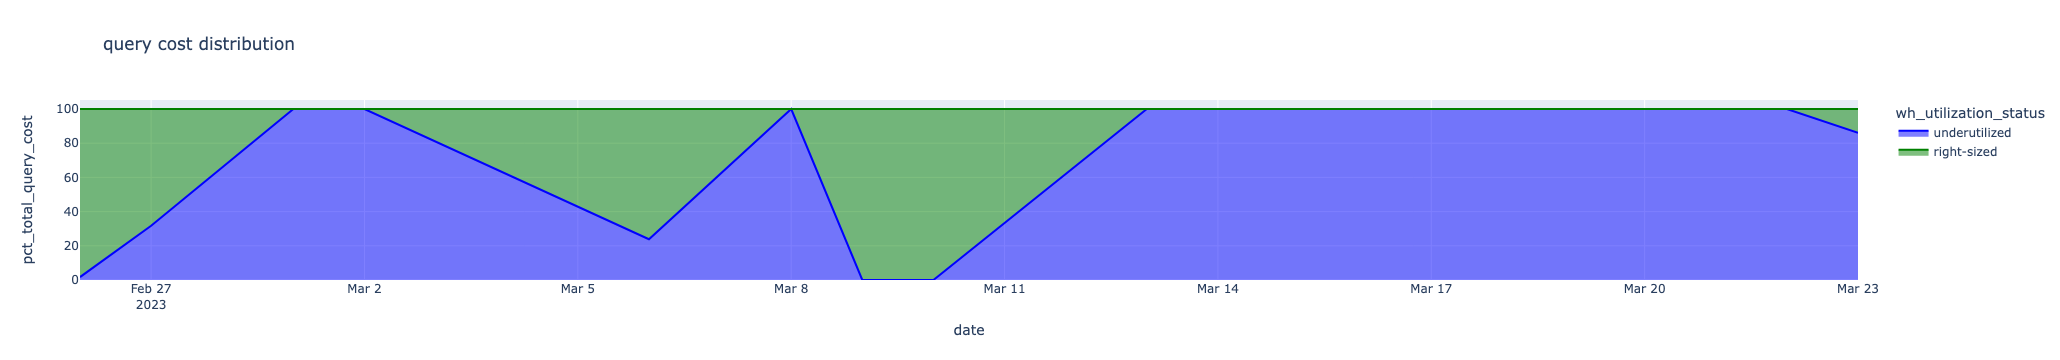

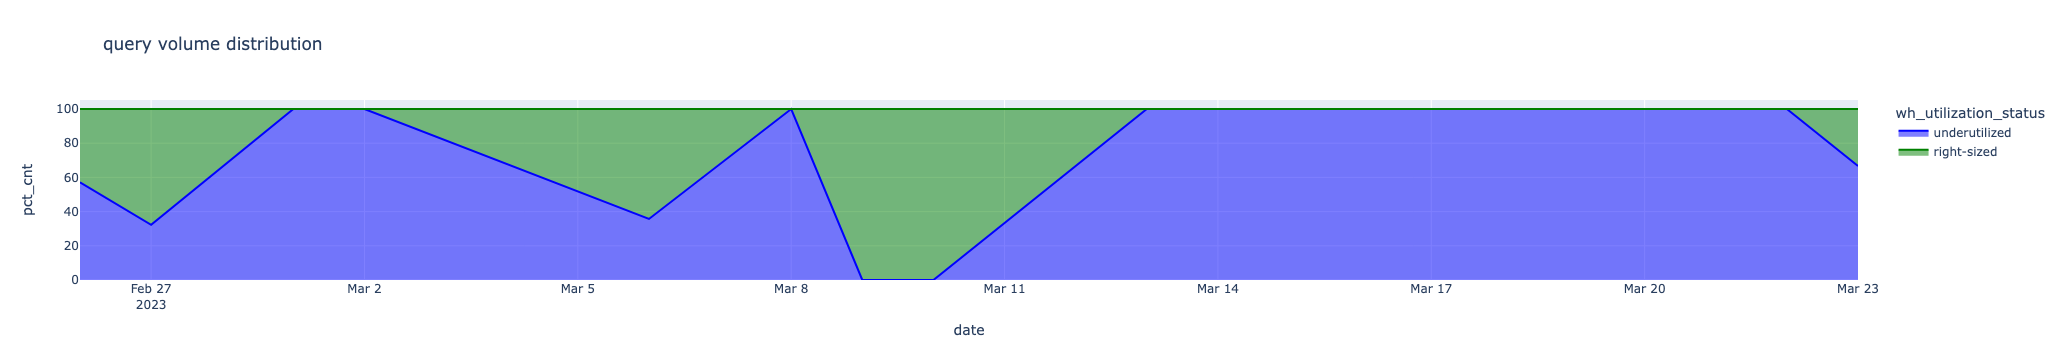

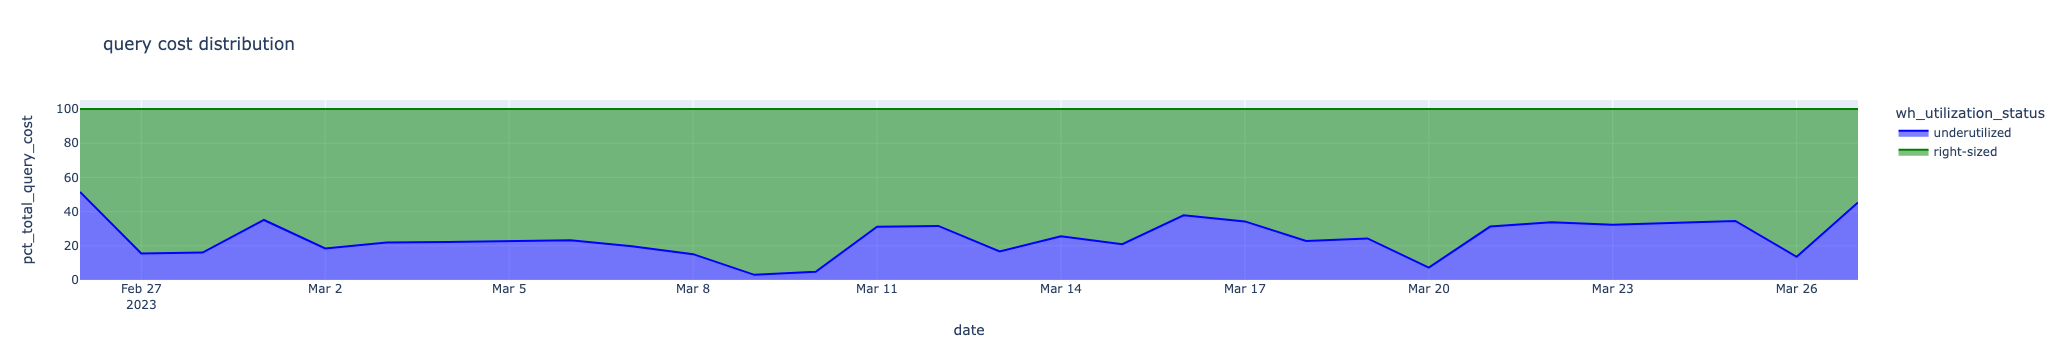

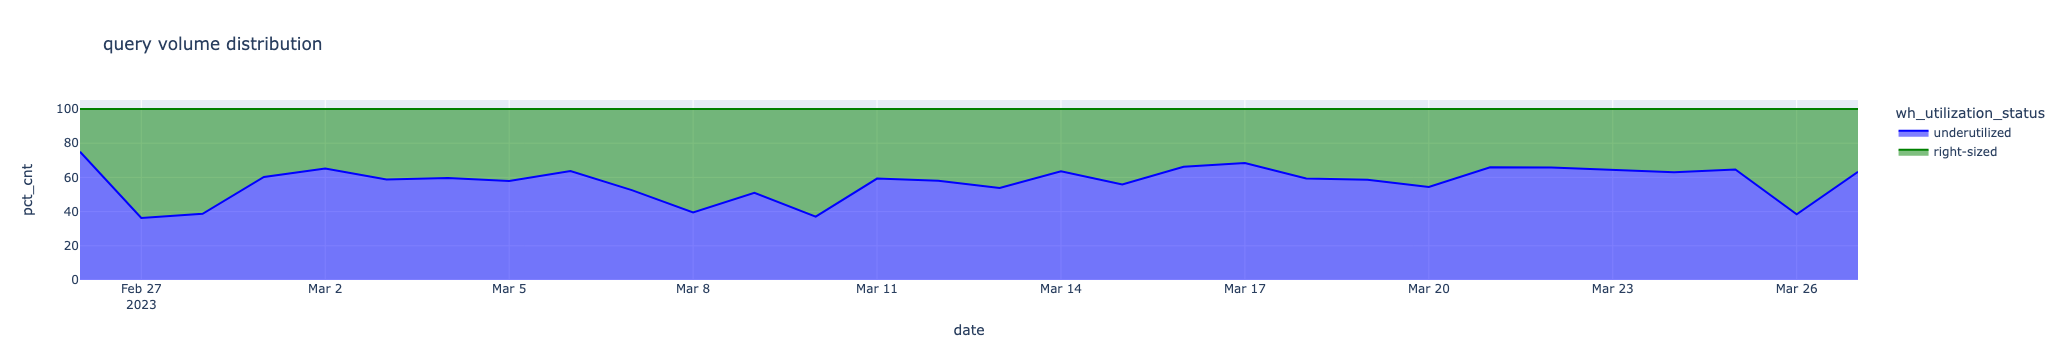

In [27]:

warehouses = df.warehouse_name.unique()
for wh in warehouses[0:10]:

    fig = px.area(
        df[df.warehouse_name == wh], 
        x="date", 
        y="pct_total_query_cost", 
        color = 'wh_utilization_status', 
        color_discrete_sequence=['blue', 'green', 'red'],
        title = "query cost distribution"
    )
    fig.update_layout(hovermode="x")
    fig.show()

    fig = px.area(
        df[df.warehouse_name == wh], 
        x="date", y="pct_cnt", 
        color = 'wh_utilization_status', 
        color_discrete_sequence=['blue', 'green', 'red'],
        title = "query volume distribution"
    )
    fig.update_layout(hovermode="x")

    fig.show()